In [1]:
fpath = '/Users/yungkuo/Google Drive/vsNR result sharing space/Anastasia/exp1 3_10_16/'
fname = 'cell1_S2_voltage steps_10Hz'
bfname = 'cell1_bf'

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tff
import ROI
from matplotlib.colors import LogNorm
#%config InlineBackend.figure_format = 'retina'

## Import movie and bright-field image

In [3]:
tiffimg = tff.TiffFile(fpath+fname+'.tif')
movie = tiffimg.asarray()
movie = movie[:-31,:,:]
data = movie.shape
print('movie size = {}'.format(data))

movie size = (598, 356, 178)


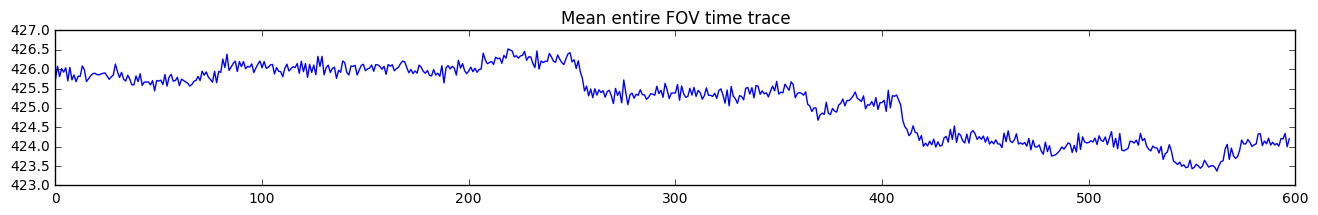

In [4]:
fig, ax = plt.subplots(figsize=(16,2))
ax.plot(movie.mean(1).mean(1))
ax.set_title('Mean entire FOV time trace')

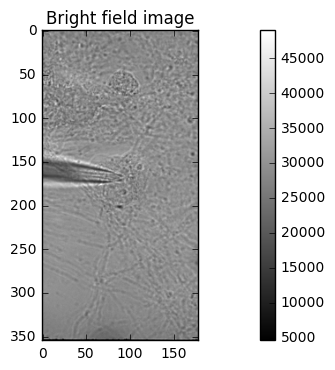

In [5]:
tiffimg = tff.TiffFile(fpath+bfname+'.tif')
bf = tiffimg.asarray()
fig, ax = plt.subplots(figsize=(16,4))
im = ax.imshow(bf, cmap='gray')
plt.colorbar(im)
plt.title('Bright field image')

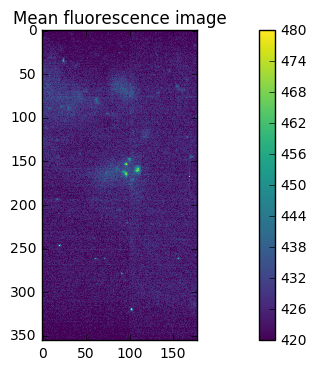

In [6]:
image = movie.mean(0)
fig, ax = plt.subplots(figsize=(16,4))
im = ax.imshow(image, cmap='viridis', vmin=420, vmax=480, interpolation='none')
plt.colorbar(im)
plt.title('Mean fluorescence image')

## Import IV curves

In [8]:
from neo import io
r = io.AxonIO(fpath+'cell1_S2_voltage steps'+'.abf')
bl = r.read_block()

/Users/yungkuo/anaconda/lib/python3.5/site-packages/neo/io/axonio.py:261: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  nbchannel)).astype('f')


In [9]:
import matplotlib
cmap = matplotlib.cm.gnuplot

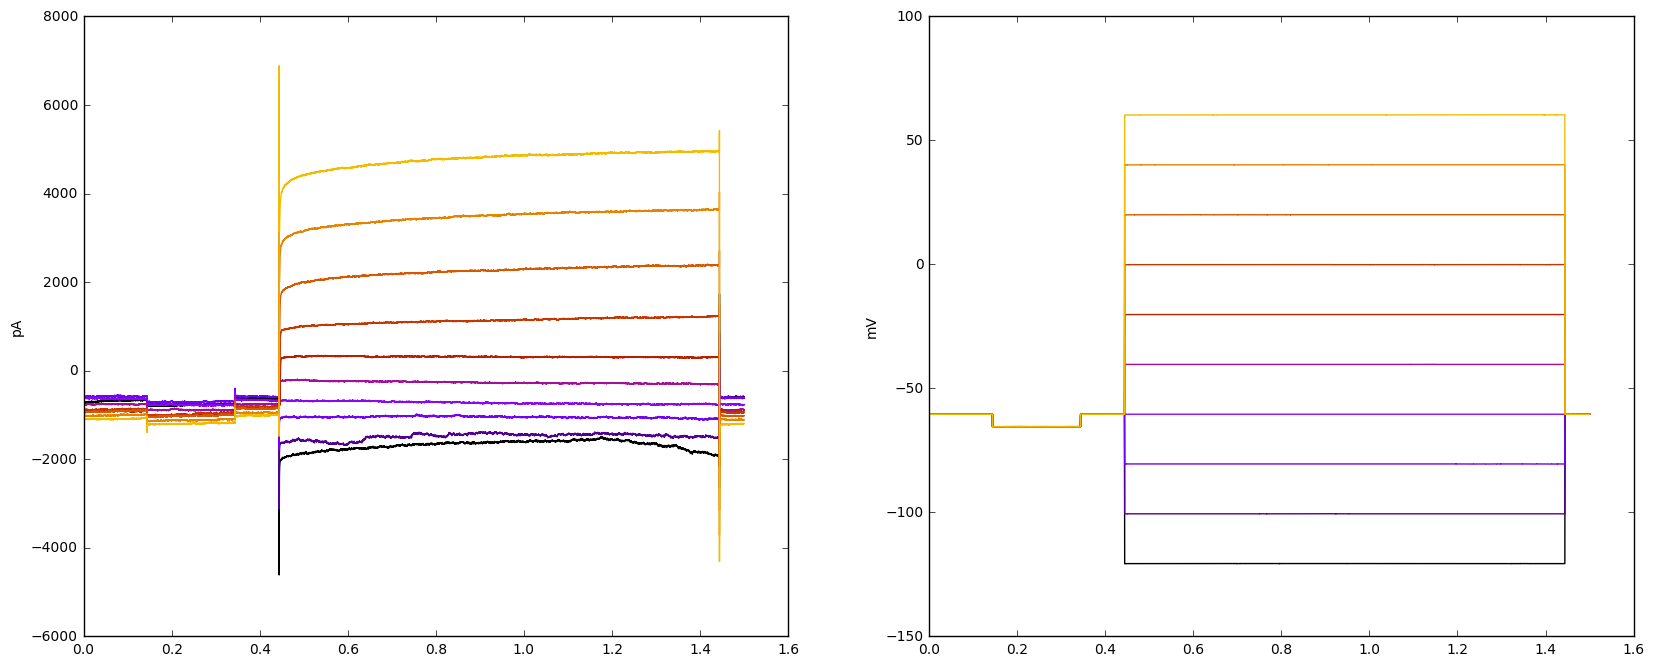

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
for i, seg in enumerate(bl.segments):
    ax[0].plot(np.arange(len(seg.analogsignals[0]))/10000, seg.analogsignals[0], color=cmap(i/len(bl.segments)))
    ax[1].plot(np.arange(len(seg.analogsignals[0]))/10000, seg.analogsignals[1], color=cmap(i/len(bl.segments)))
    ax[0].set_ylabel('pA')
    ax[1].set_ylabel('mV')

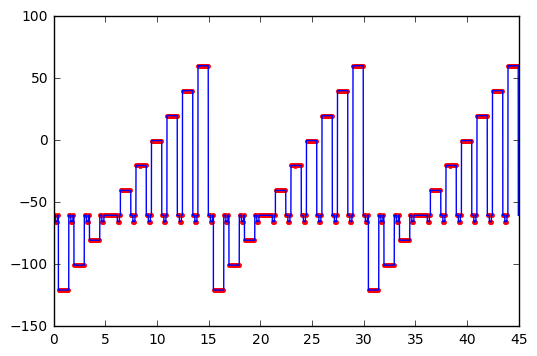

In [11]:
V = []
for i, seg in enumerate(bl.segments):
    V = np.append(V, seg.analogsignals[1])
V = np.tile(np.array(V), 3)
T = np.linspace(0, 45, len(V))
plt.plot(T[::1000], V[::1000], 'r.')
plt.plot(T, V, 'b-')

### Threshold mask

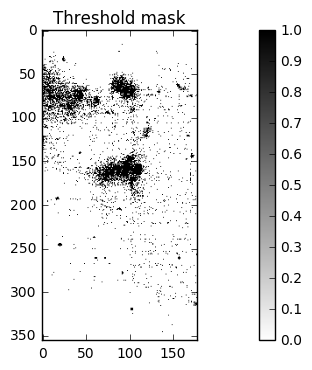

In [12]:
threshold = 430
mask = image>threshold
fig, ax = plt.subplots(figsize=(16,4))
im = ax.imshow(mask, cmap='gray_r')
fig.colorbar(im)
ax.set_title('Threshold mask')

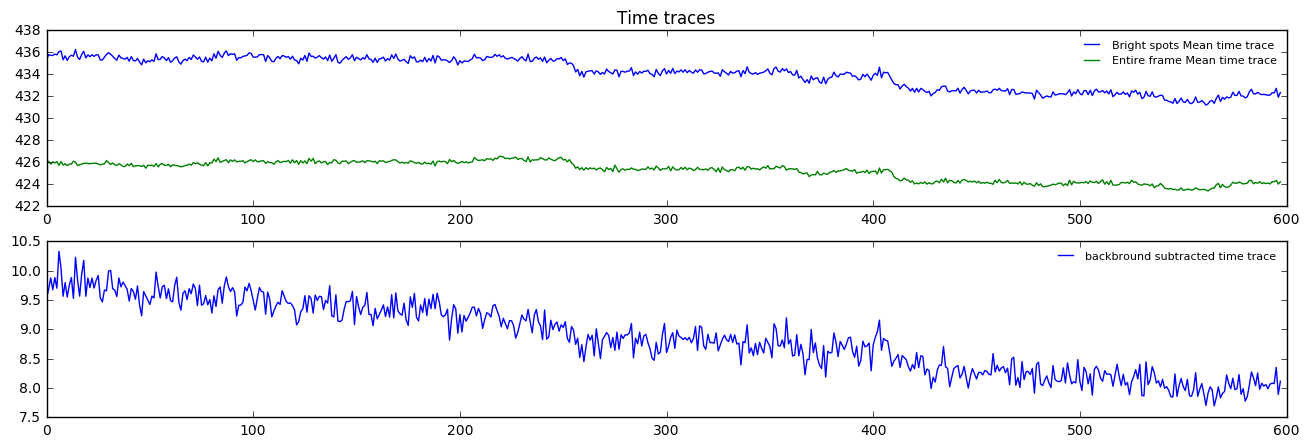

In [13]:
sg = (mask*movie).sum(1).sum(1)/mask.sum()
avg = movie.mean(1).mean(1)

fig, ax = plt.subplots(2, figsize=(16,5))
ax[0].plot(sg, label='Bright spots Mean time trace')
ax[0].plot(avg, label='Entire frame Mean time trace')
ax[0].set_title('Time traces')
ax[1].plot(sg-avg, label='backbround subtracted time trace')
ax[0].legend(frameon=False, fontsize=8)
ax[1].legend(frameon=False, fontsize=8)

### Background subtraction

In [14]:
movie_bs = np.zeros(data)
for i in range(data[0]):
    movie_bs[i,:,:] = movie[i,:,:] - (np.sum(movie[i,:,:]*(~mask))/np.sum(~mask))
#movie_bs = movie

### Select Particles

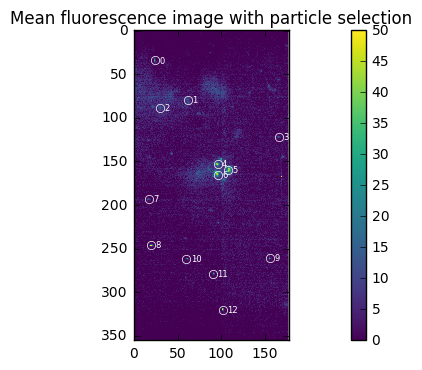

In [17]:
scan = [2,2]
image = movie_bs.mean(0)
pts = ROI.finddot(image, scan, 1.2)

fig, ax = plt.subplots(figsize=(16,4))
ax.plot(pts[:,0], pts[:,1], 'wo', fillstyle='none')
im = ax.imshow(image, cmap='viridis', vmin=0, vmax=50, interpolation='none')
for count, pt in enumerate(pts):
    ax.annotate(count, xy=pt+[5,3], color='w', fontsize=6)
plt.colorbar(im)
plt.title('Mean fluorescence image with particle selection')

In [16]:
len(pts)

10

### Manual assign particles on patched cell

#pts = pts[36:80,:]
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(pts[:,0], pts[:,1], 'wo', fillstyle='none')
im = ax.imshow(image, cmap='viridis', vmin=0, vmax=102, interpolation='none')
for count, pt in enumerate(pts):
    ax.annotate(count, xy=pt+[5,3], color='w', fontsize=6)
plt.colorbar(im)
plt.title('Mean fluorescence image with particle selection')

In [18]:
# Exp1 Cell3 patched_pt = np.array([31,32,35,36,38,46,34,43,28])
# Exp3 cell2_1 patched_pt = np.array([70])
patched_pt = np.array([6,11,9])

### Select square ROI

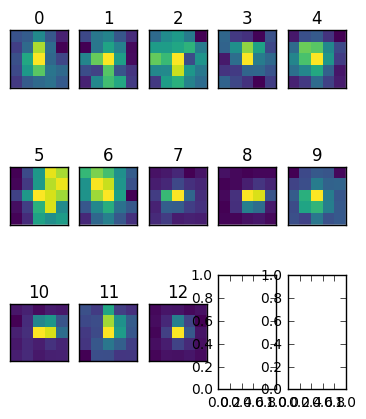

In [19]:
fig, ax = plt.subplots(3, len(pts)//3+np.all(len(pts)%3), figsize=(len(pts)/3,5))
ax = ax.ravel()
for count, pt in enumerate(pts):
    roi = ROI.get_roi_square(pt, scan)
    ax[count].imshow(image[roi], cmap='viridis', interpolation='none')
    ax[count].set_title(count)
    ax[count].set_xticks([])
    ax[count].set_yticks([])

### Select round ROI

In [20]:
for count, pt in enumerate(pts):
    pt_new = ROI.get_COM_within_roi(image, pt, [2,2])
    #print(pt, pt_new)
    pts[count] = pt_new

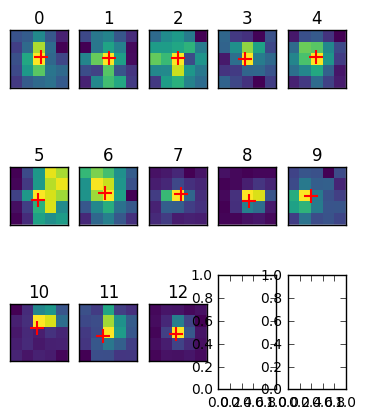

In [21]:
fig, ax = plt.subplots(3, len(pts)//3+np.all(len(pts)%3), figsize=(len(pts)/3,5))
ax = ax.ravel()
for count, pt in enumerate(pts):
    rpt = np.round(pt)
    roi = ROI.get_roi_square(rpt, scan)
    ax[count].plot(pt[0], pt[1], 'r+', ms=10, mew=1.5)
    ax[count].imshow(image[roi], cmap='viridis', interpolation='none',
                   extent=(roi[1].start-0.5, roi[1].stop-0.5, roi[0].stop-0.5, roi[0].start-0.5))
    ax[count].set_title(count)
    ax[count].set_xticks([])
    ax[count].set_yticks([])

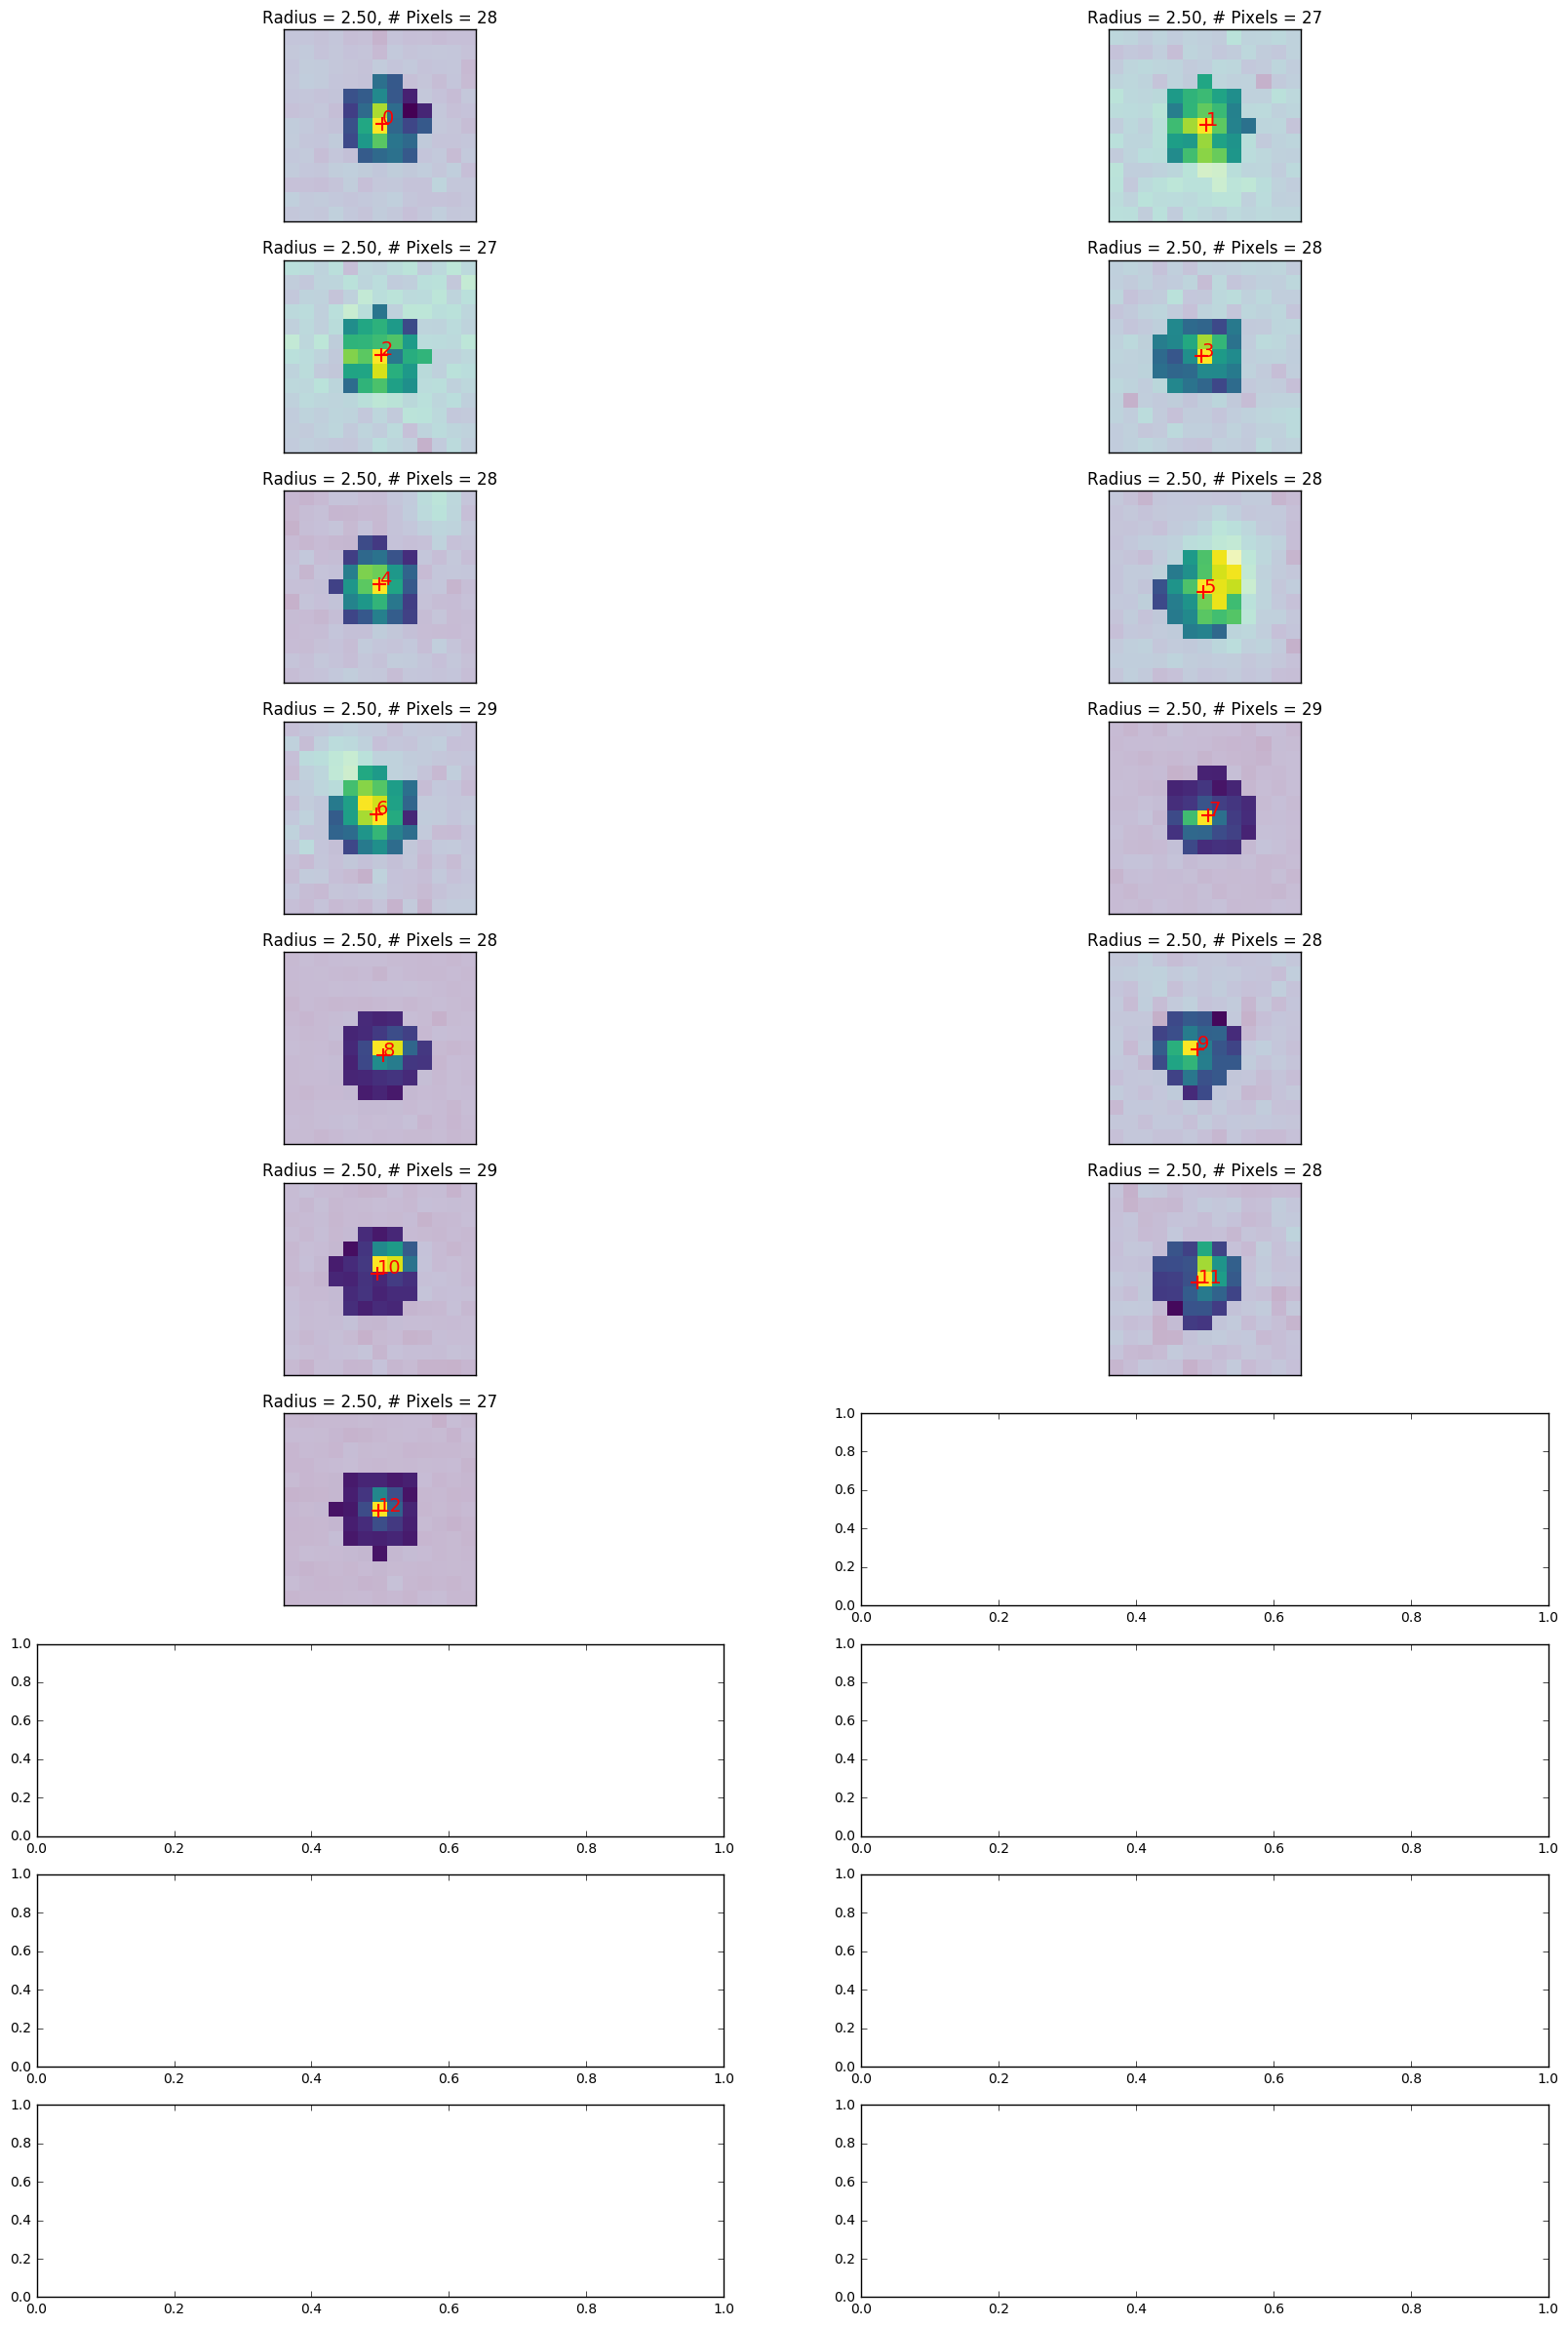

In [22]:
pad = (6, 6)
clip_radius = 2.5

fig, ax = plt.subplots(10, len(pts)//10+np.all(len(pts)%10), figsize=(20,30))
ax = ax.ravel()
for count, pt in enumerate(pts):
    rpt = np.round(pt)
    roi = ROI.get_roi_square(rpt, pad)
    ax[count].imshow(image[roi], cmap='viridis', interpolation='none', 
                     extent=(roi[1].start-0.5, roi[1].stop-0.5, roi[0].stop-0.5, roi[0].start-0.5))
    ax[count].plot(pt[0], pt[1], 'r+', ms=10, mew=1.5)
    ax[count].annotate('%d' % count, pt, color='red', fontsize=14)
    
    mask = ROI.get_roi_circle(pt, clip_radius, data[1:])
    a = np.ones(data[1:])
    a[mask] = 0
    im = ax[count].imshow(a[roi], interpolation='none', cmap='gray', vmin=0.5, alpha=0.7, 
                          extent=(roi[1].start-0.5, roi[1].stop-0.5, roi[0].stop-0.5, roi[0].start-0.5))
    im.cmap.set_under(alpha=0)
    ax[count].set_title('Radius = %.2f, # Pixels = %d' % (clip_radius, len(mask[0])))
    ax[count].set_xticks([])
    ax[count].set_yticks([])

### Selected particle's ROI as function of time

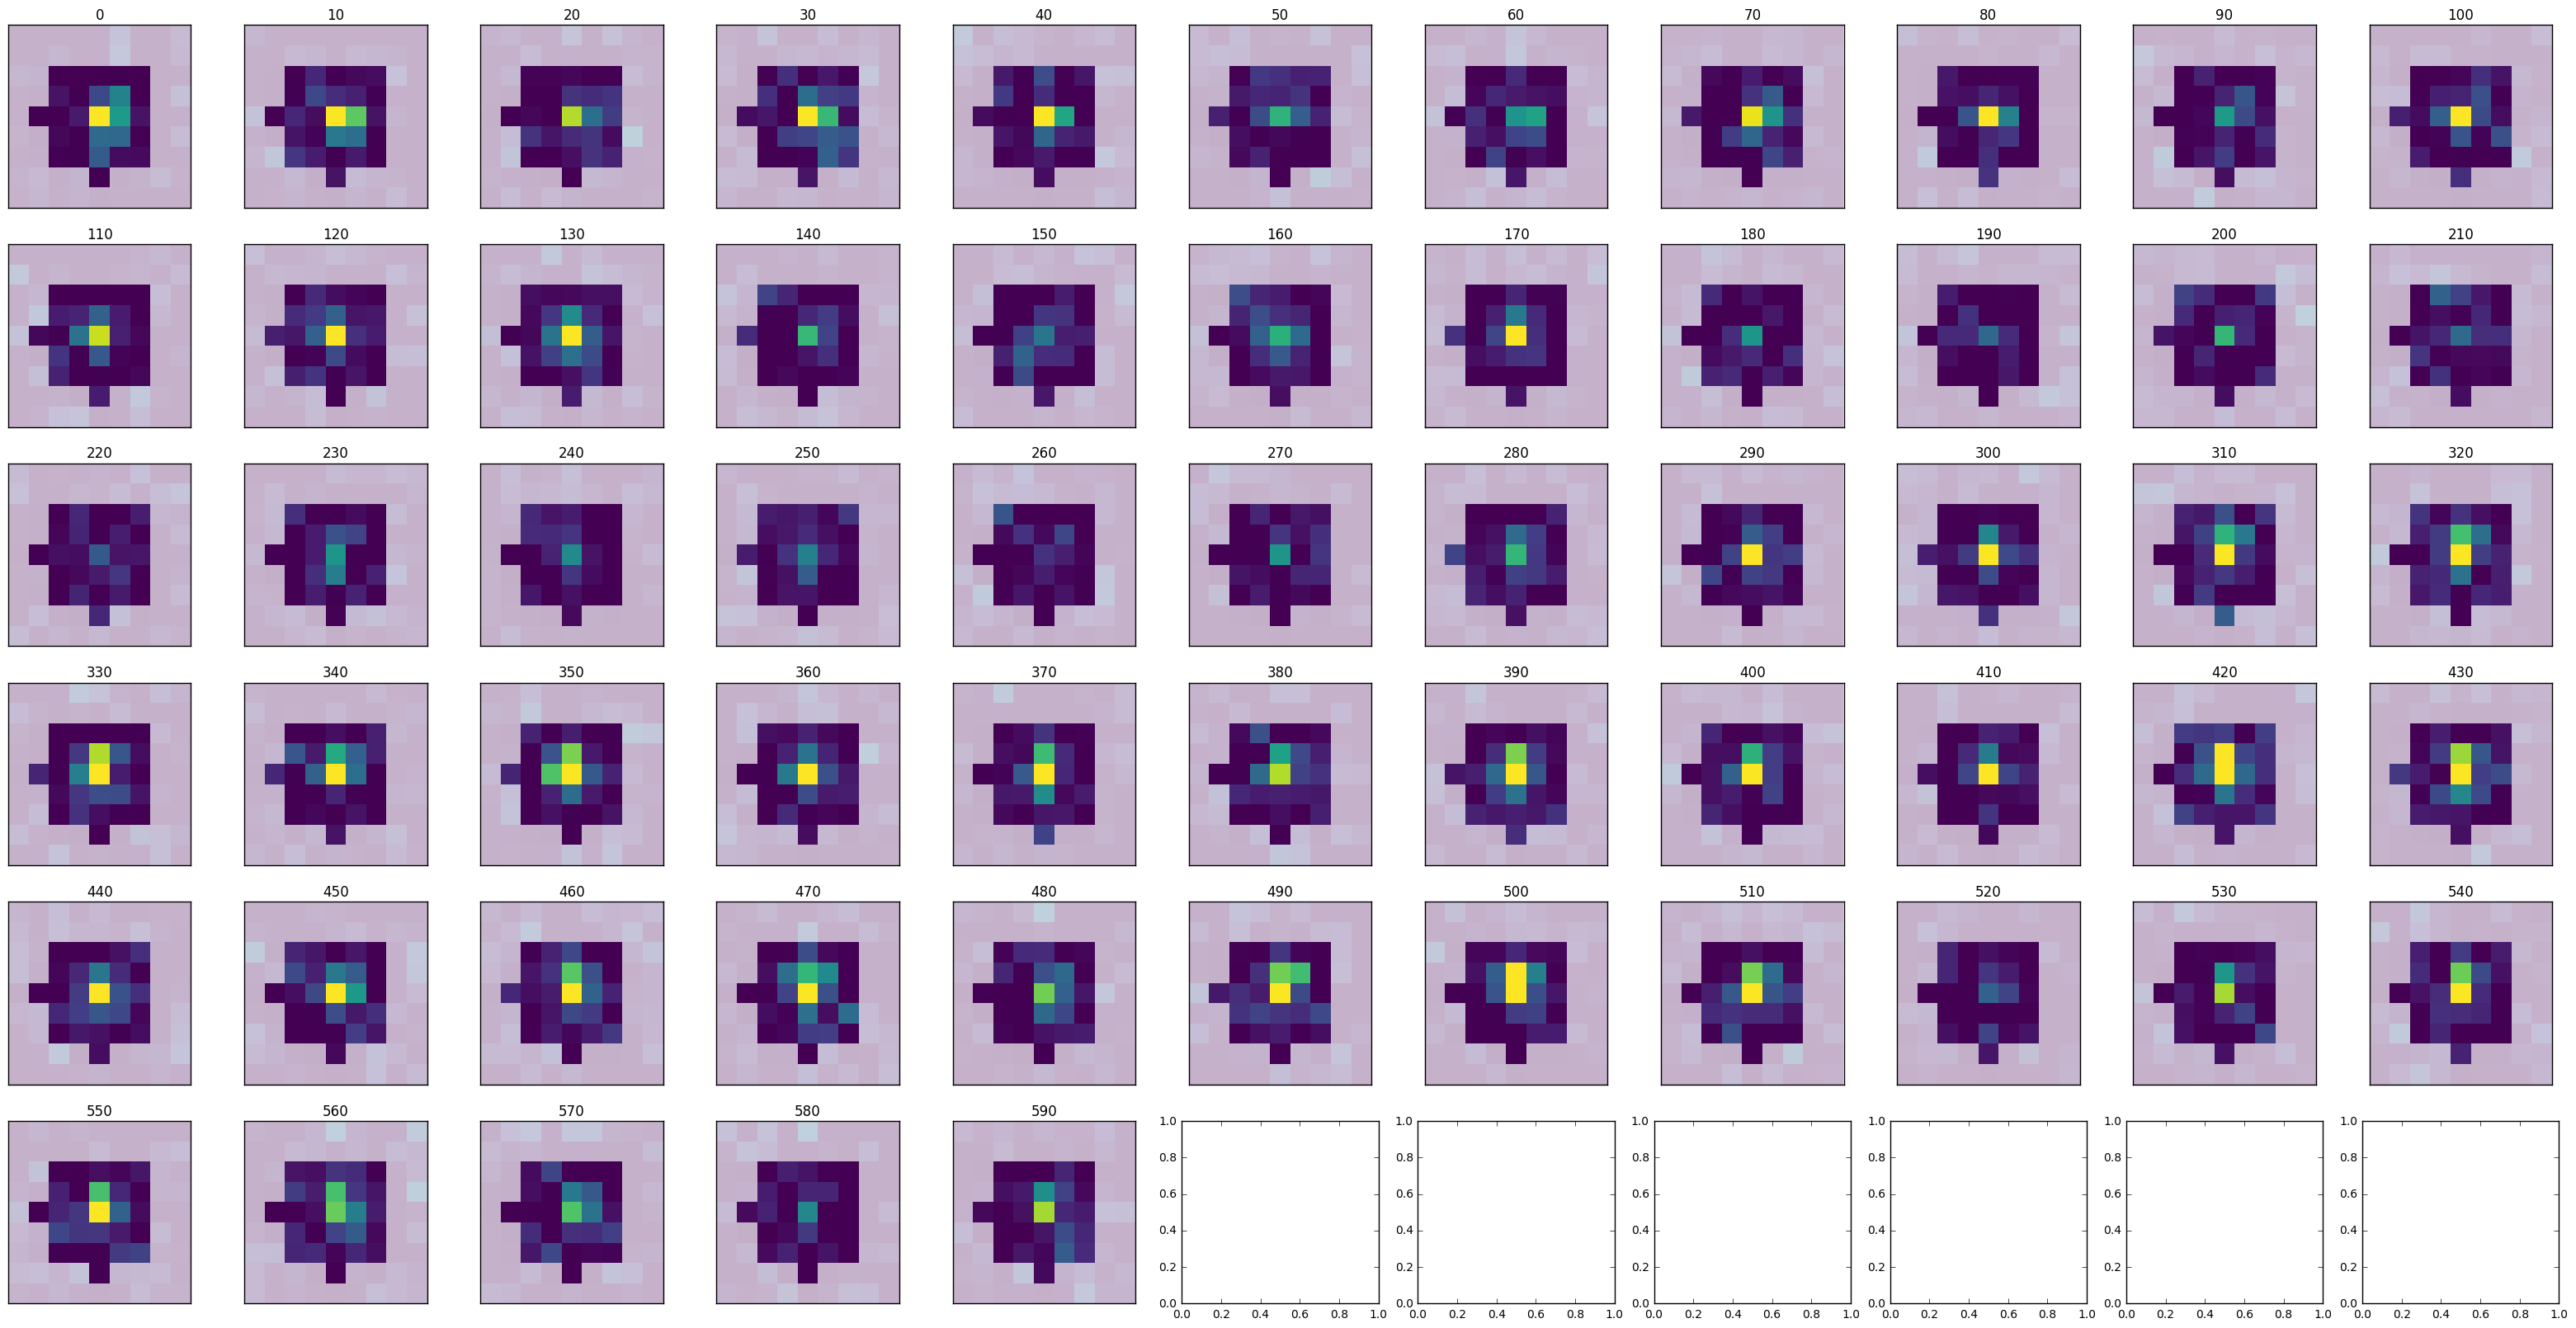

In [25]:
select_pt = 12
roi = ROI.get_roi_square_3d(np.round(pts[select_pt]), [4,4])
mask = ROI.get_roi_circle(pts[select_pt], clip_radius, data[1:])
a = np.ones(data[1:])
a[mask] = 0
    
fig, ax = plt.subplots(6, 11, figsize=(40,20))
ax = ax.ravel()
for count, i in enumerate(range(0, data[0], 10)):
    ax[count].imshow(movie_bs[roi][i,:,:], cmap='viridis', vmin=0, vmax=100, interpolation='none',
                    extent=(roi[2].start-0.5, roi[2].stop-0.5, roi[1].stop-0.5, roi[1].start-0.5))
    im = ax[count].imshow(a[roi[1:]], interpolation='none', cmap='gray', vmin=0.5, alpha=0.7, 
                          extent=(roi[2].start-0.5, roi[2].stop-0.5, roi[1].stop-0.5, roi[1].start-0.5))
    im.cmap.set_under(alpha=0)
    ax[count].set_title(i)
    ax[count].set_xticks([])
    ax[count].set_yticks([])

### Time traces of single particles (spots)

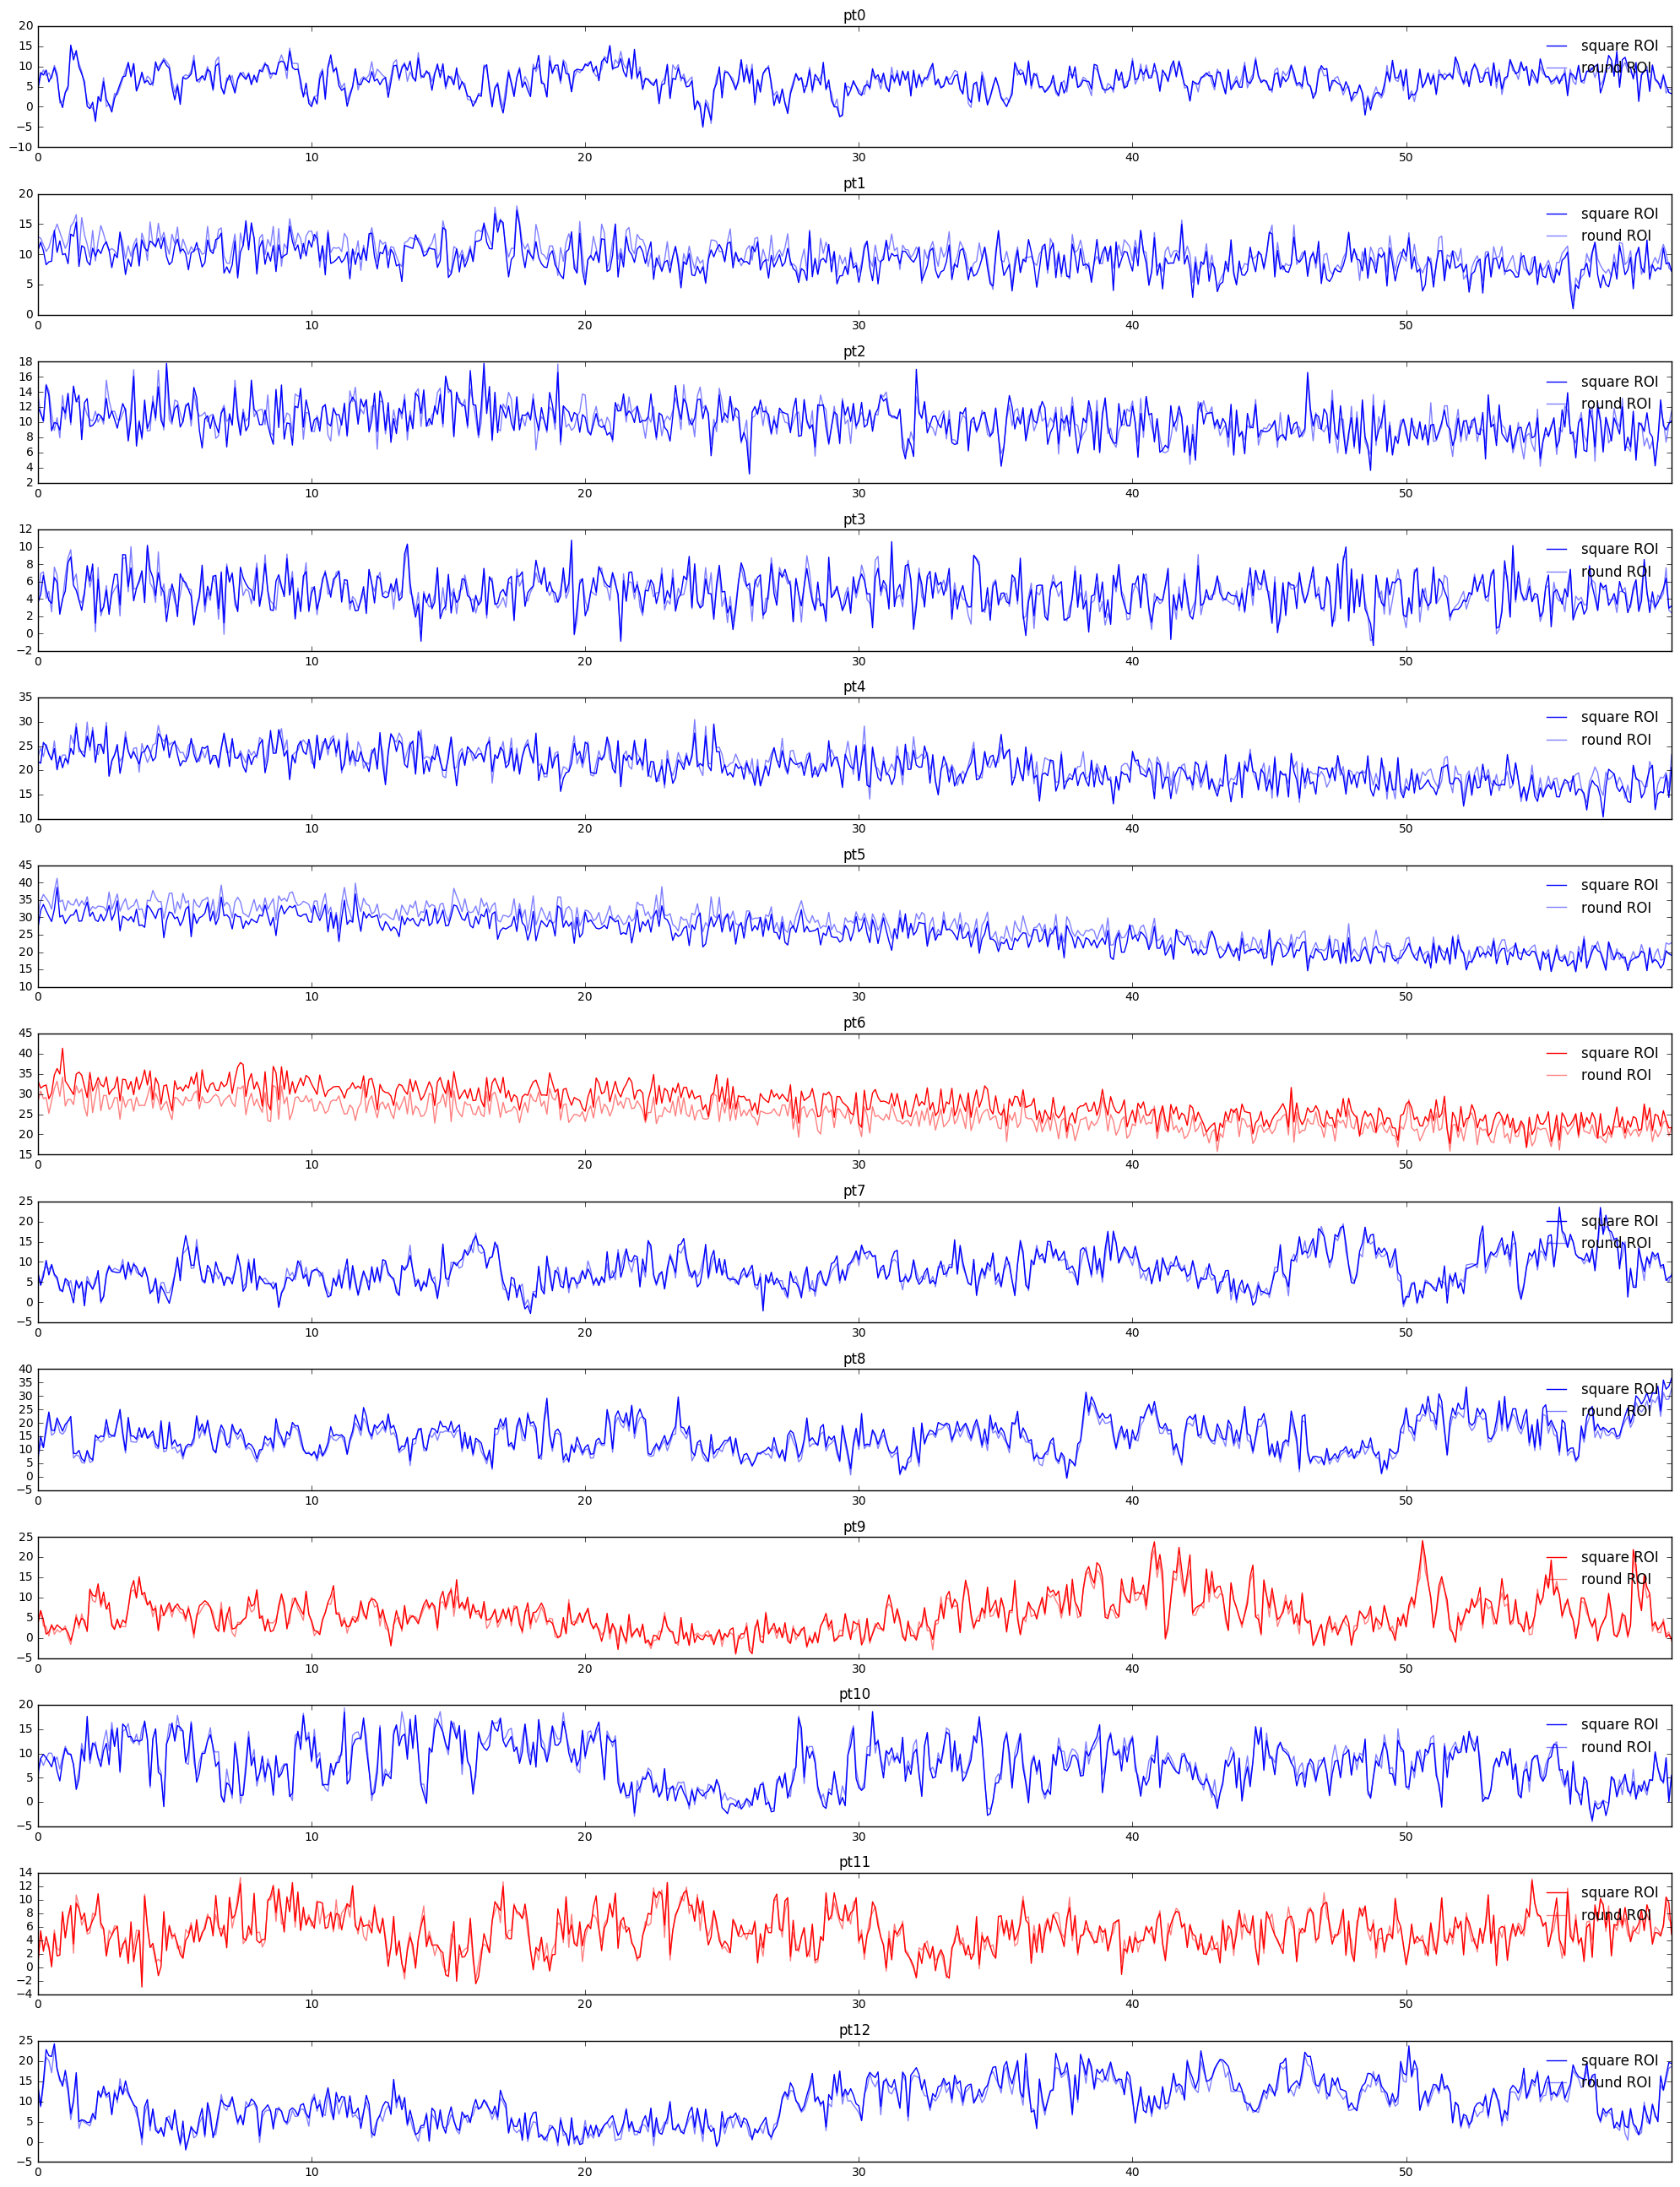

In [26]:
T = np.arange(data[0])*0.1
fig, ax = plt.subplots(len(pts), figsize=(20,len(pts)*2))
for count, pt in enumerate(pts):
    color = 'b'
    if not (patched_pt-count).all():
        color = 'r'
    tt = ROI.get_timetrace(movie_bs, pt, scan)
    ttr = ROI.get_timetrace_circle(movie_bs, pt, clip_radius)
    ax[count].plot(T, tt, color=color, label='square ROI')
    ax[count].plot(T, ttr, color=color, alpha=0.5, label='round ROI')
    ax[count].set_title('pt{}'.format(count))
    ax[count].set_xlim(T.min(), T.max())
    ax[count].legend(frameon=False)
fig.tight_layout()

### Fluorescence-V cross correlation curves

In [27]:
ccr = {}
for count, pt in enumerate(pts):
    tt = ROI.get_timetrace(movie_bs, pt, scan)
    tt = tt[100:] - np.mean(tt)
    ccr1 = np.correlate(tt, V[::1000], mode='valid')
    ccr[count] = ccr1

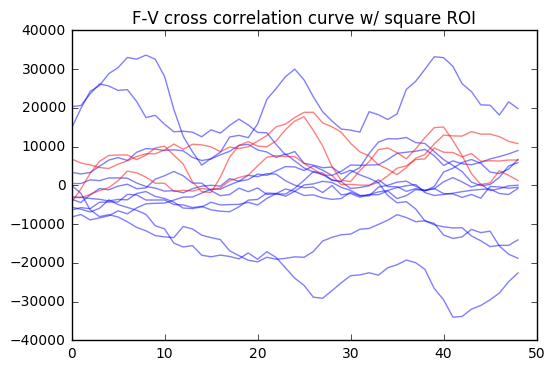

In [28]:
fig, ax = plt.subplots()
for count in range(len(pts)):
    color = 'b'
    if not (patched_pt-count).all():
        color = 'r'
    ax.plot(ccr[count], color=color, alpha=0.5, label='pt{}'.format(count))
ax.set_title('F-V cross correlation curve w/ square ROI')

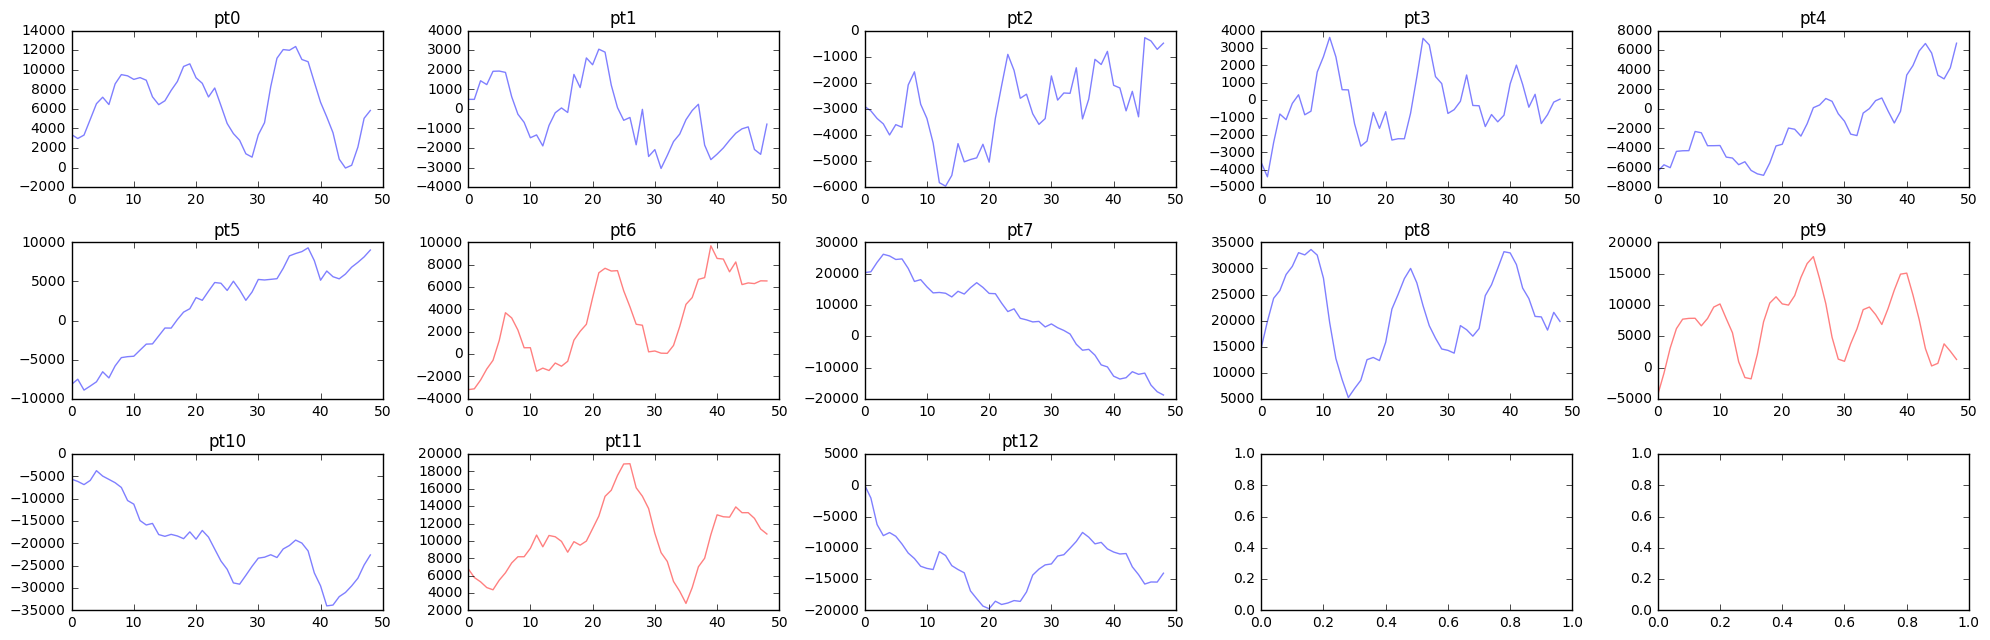

In [29]:
fig, ax = plt.subplots(len(pts)//5+np.all(len(pts)%5), 5, figsize=(20,len(pts)/2))
ax = ax.ravel()
for count in range(len(pts)):
    color = 'b'
    if not (patched_pt-count).all():
        color = 'r'
    ax[count].plot(ccr[count], color=color, alpha=0.5, label='pt{}'.format(count))
    ax[count].set_title('pt{}'.format(count))
    #ax[count].set_ylim(-120000, 120000)
fig.tight_layout()

In [30]:
ccr_r = {}
for count, pt in enumerate(pts):
    ttr = ROI.get_timetrace_circle(movie_bs, pt, clip_radius)
    ttr = ttr[100:] - np.mean(ttr)
    ccr1 = np.correlate(ttr, V[::1000], mode='valid')
    ccr_r[count] = ccr1

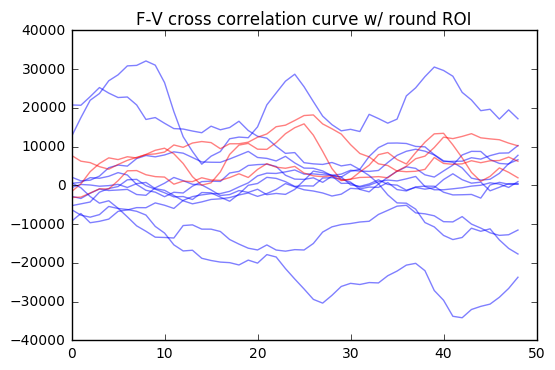

In [31]:
fig, ax = plt.subplots()
for count in range(len(pts)):
    color = 'b'
    if not (patched_pt-count).all():
        color = 'r'
    ax.plot(ccr_r[count], color=color, alpha=0.5, label='pt{}'.format(count))
ax.set_title('F-V cross correlation curve w/ round ROI')

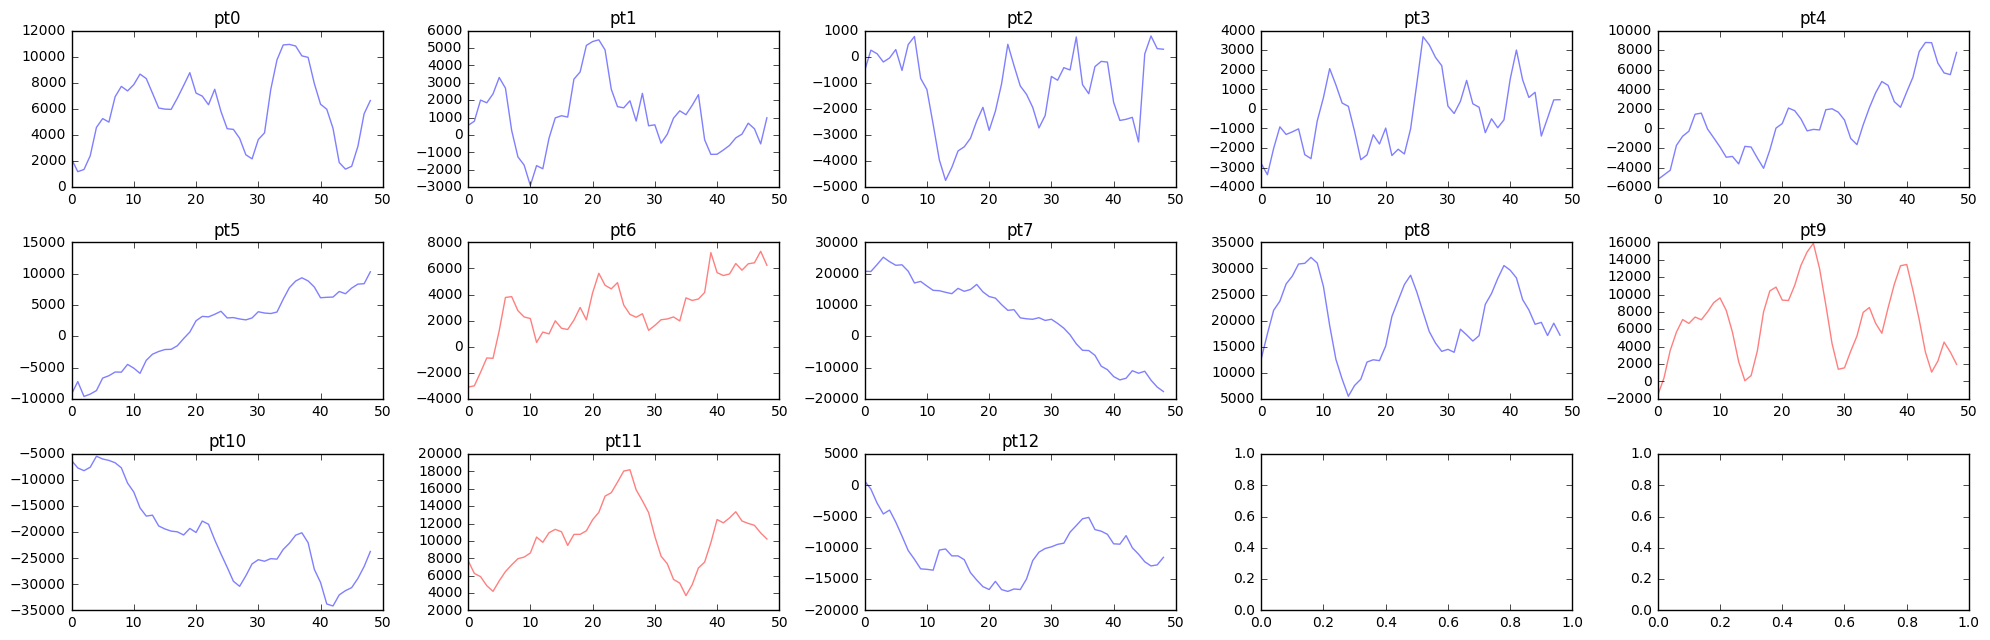

In [32]:
fig, ax = plt.subplots(len(pts)//5+np.all(len(pts)%5), 5, figsize=(20,len(pts)/2))
ax = ax.ravel()
for count in range(len(pts)):
    color = 'b'
    if not (patched_pt-count).all():
        color = 'r'
    ax[count].plot(ccr_r[count], color=color, alpha=0.5, label='pt{}'.format(count))
    ax[count].set_title('pt{}'.format(count))
    #ax[count].set_ylim(-120000, 120000)
fig.tight_layout()

### Cross correlation score 

In [33]:
def get_ccr_score(movie, pt, pad):
    tt = ROI.get_timetrace(movie, pt, pad)
    tt = tt[100:] - np.mean(tt)
    ccr = np.correlate(tt, V[::1000], mode='valid')
    ccrs = np.sum(ccr-np.mean(ccr))
    return ccrs

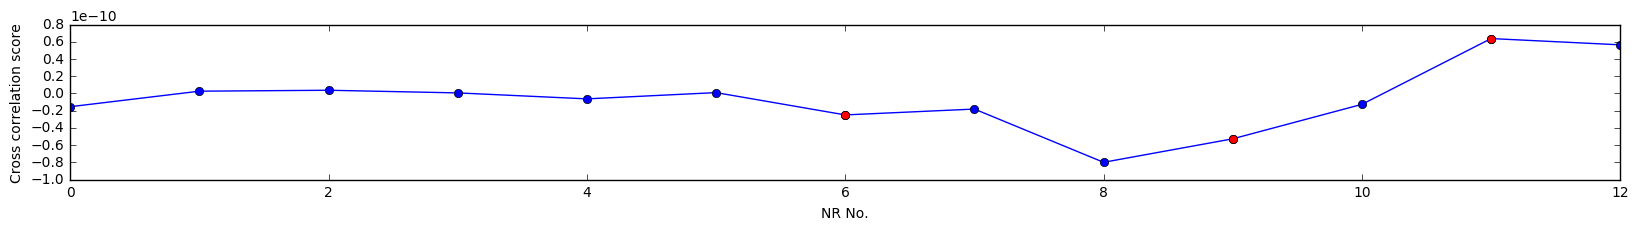

In [34]:
ccr_score = np.zeros(len(pts))
for count, pt in enumerate(pts):
    ccrs = get_ccr_score(movie_bs, pt, scan)
    ccr_score[count] = ccrs

fig, ax = plt.subplots(figsize=(20,2))
ax.plot(ccr_score, 'bo-')
ax.plot(patched_pt, ccr_score[patched_pt], 'ro', )
ax.set_xlabel('NR No.')
ax.set_ylabel('Cross correlation score')

In [35]:
high_ccr_score_pt = np.abs(ccr_score) > (np.abs(ccr_score.mean()) + 2*np.std(ccr_score))
high_ccr_score_pt = np.where(high_ccr_score_pt)[0]

In [36]:
high_ccr_score_pt 

array([8])

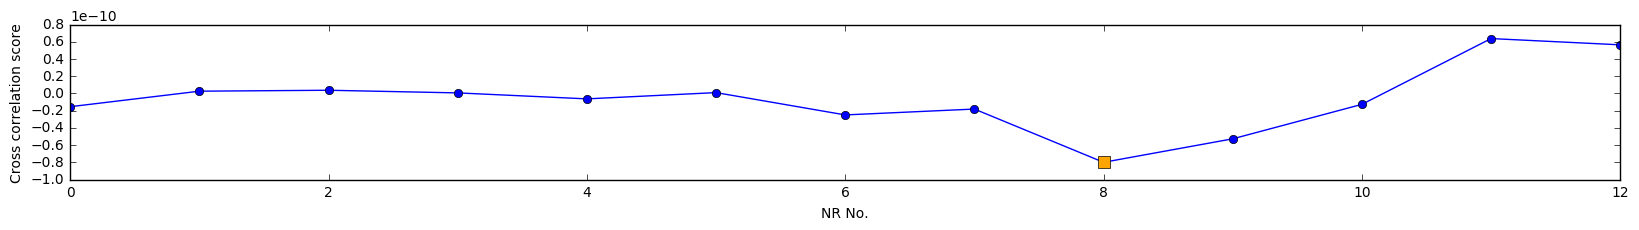

In [37]:
fig, ax = plt.subplots(figsize=(20,2))
ax.plot(ccr_score, 'bo-')
ax.plot(high_ccr_score_pt, ccr_score[high_ccr_score_pt], 's', color='orange', markersize=8)
ax.set_xlabel('NR No.')
ax.set_ylabel('Cross correlation score')

### Fluorescence-V cross correlation map

In [38]:
binning = 2 # bin = binning*2+1 e.g. 1 -> 3x3 pixels, 2 -> 5x5 pixels
ccr_map = np.zeros(data[1:])
for i in range(data[1]):
    for j in range(data[2]):
        ccr_map[i,j] = get_ccr_score(movie_bs, [j,i], [binning, binning])

/Users/yungkuo/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


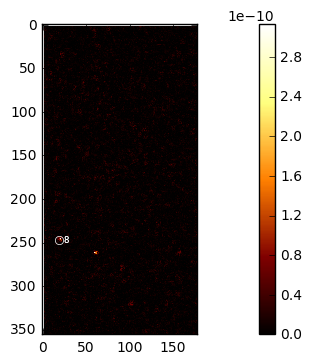

In [39]:
fig, ax = plt.subplots(figsize=(16,4))
#ax.plot(pts[:,0], pts[:,1], 'co', fillstyle='none')
#for count, pt in enumerate(pts):
#    ax.annotate(count, xy=pt+[5,3], color='c', fontsize=6)
for i in high_ccr_score_pt:
    ax.plot(pts[i,0], pts[i,1], 'wo', fillstyle='none')
    for count, pt in enumerate(pts[i]):
        ax.annotate(i, xy=pts[i]+[5,3], color='w', fontsize=6)
im = ax.imshow(np.abs(ccr_map), interpolation='none', cmap='afmhot')
plt.colorbar(im)